# Analysis Of Binghamton University's Men's Ultimate Frisbee Stats



In [6]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from Player import *
from Main import processActions


## To get specific games: # blazeGame = playersDF.loc[:,'games']['Blaze'][('Cav Cup', 'Navy y')]
pd.set_option('display.precision', 2)
pd.set_option('display.max_columns', None)
df = pd.read_csv('BigBearStats.csv', index_col=2)
badColumns = ['Date/Time', 'Point Elapsed Seconds','Player 7', 'Player 8', 
           'Player 9', 'Player 10', 'Player 11', 'Player 12', 'Player 13', 'Player 14', 
           'Player 15', 'Player 16', 'Player 17', 'Player 18', 'Player 19', 'Player 20', 
           'Player 21', 'Player 22', 'Player 23', 'Player 24', 'Player 25', 'Player 26', 
           'Player 27', 'Elapsed Time (secs)', 'Begin X', 'Begin Y', 'End X', 'End Y', 
           'Distance Unit of Measure', 'Absolute Distance', 'Lateral Distance', 'Toward Our Goal Distance', 'Begin Area', 'End Area']
def getPlayers(df):
    players = {}
    playerColNames = ['Player 0', 'Player 1', 'Player 2', 'Player 3', 'Player 4', 'Player 5', 'Player 6']
    for col in playerColNames:
        for playerName in df[col]:
            curPlayer = Player(playerName)
            players.update({playerName: curPlayer})
    return players
df = df.drop(badColumns, axis=1)
players = getPlayers(df) 
playersDF = pd.DataFrame.from_records((vars(player) for player in list(players.values())), index='name')
df = df.rename(columns={'Tournamemnt': 'Tournament'})
players, pullsHangTime = processActions(df, players)
playersDF = pd.DataFrame.from_records((vars(player) for player in list(players.values())), index='name')
playersDF.drop(['pointsWhenPlaying', 'opsToScore', 'games','numGamesPlayed', 'pulls'], axis=1, inplace=True)
# # playersDF.sort_values(by=['chanceOfScoring'])
playersDF


,pointsPlayed,goals,assists,assistsToAssists,catches,ogPlusMinus,plusMinus,throwaways,drops,ds,completions,obPulls,avgPullHangtime,passingPercent,catchingPercent,chanceOfScoring
name,,,,,,,,,,,,,,,,
Blaze,76,9,10,5,93,10,9.60,14,4,9,72,0,5.75,0.84,24.25,0.36
Ty,73,5,0,1,16,7,7.55,2,1,5,10,0,4.12,0.83,17.00,0.36
Chris,88,5,5,3,55,4,4.75,9,2,5,52,0,0.00,0.85,28.50,0.33
Billy,67,2,10,9,133,1,-0.60,11,2,2,173,0,4.51,0.94,67.50,0.32
Lebron,69,4,0,0,9,7,7.30,1,0,4,4,0,0.00,0.80,0.00,0.36
Ian,68,3,9,4,63,11,10.55,8,0,7,65,2,5.27,0.89,0.00,0.40
Matt,21,2,1,0,10,-1,-1.50,2,2,0,5,0,0.00,0.71,6.00,0.25
C^2,62,4,2,1,25,7,5.20,2,0,3,18,0,0.00,0.90,0.00,0.27
Ryan,4,0,1,0,5,2,1.60,0,0,1,5,0,0.00,0.00,0.00,0.25


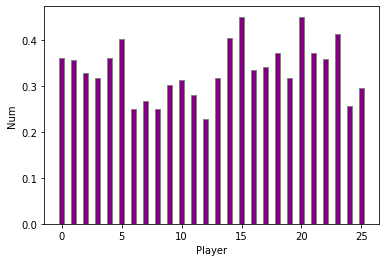

In [2]:

chanceOfScoring = playersDF.loc[:,'chanceOfScoring']
plusMinus = playersDF.loc[:,'plusMinus']
# td.plot.bar(x='name', y='ChanceOfScoring')
width = 0.4
plt.bar(np.arange(len(chanceOfScoring)), chanceOfScoring, color='purple', width=width, edgecolor='grey', label='chanceOfScoring')
# plt.bar(np.arange(len(plusMinus)) + width, plusMinus, color='yellow', width=width, edgecolor='grey', label='plusMinus')
plt.xlabel('Player')
plt.ylabel('Num')
plt.show()



